## Machine Learning in Finance
## Group Project
* This is a group project due on 08/01/2026
* Groups should have 3-5 members each.
* All projects should be completed using Jupyter notebooks which will be delivered at the end of the project. Each task should have an independent jupyter notebook, to assist in the grading.
* Please read the instructions as you also need to deliver a video.

### Project Context
Home Credit is a financial services company that provides loans to customers often underserved by traditional banking institutions. The goal is to use machine learning to assess the risk of default at the loan application stage, enabling better decision-making and optimized loan offerings. Understanding which customers are likely to default is crucial for reducing financial losses and improving operational efficiency.

### Project data
You have access to the Home Credit Default Risk dataset, along with a data dictionary to help you understand the column titles. However, you will need to explore the data yourself—not all columns will be useful, and some may require significant preprocessing. Your tasks will include:
* Cleaning the data (e.g., handling null values, resolving data type issues, addressing outliers).
* Dealing with categorical variables and feature engineering.
* Exploring which features are useful for predictive tasks and avoiding features that may leak data.

### Computation
Dealing with computation constraints is a big part of machine learning, especially as we start to deal with real world data. If at any point you are trying to run an algorithm or approach that is taking a long time to solve on google colab you have a couple of options:
* You can try running it on your laptop directly, in case your laptop or computer is faster.
* You can try to reduce the complexity of the model.
* You can reduce the complexity of the data by reducing the number of columns you use at a time.
* You can just take a smaller sample of the data (less rows) and apply the algorithm / model to this.

#### Grading
* Important you will mostly be graded on your ability to apply the machine learning approaches we have learned in class properly. So please include the work that you test and not just the final best model.
* You might receive extra points for demonstrating the ability to apply approaches not covered in the class.
* What your final model is (and how well it performs) matters much less than your ability to correctly apply different approaches, explore the problem, and understand the final results and model. Please try to demonstrate in the notebooks and the video.
* Well organized Jupyter notebooks and code will help ensure that your intentions are communicated and are likely to increase your 


**Group Members:**

1. 20221960 - Renato Bernardino
2. 20221899 - David Duarte


## Task 2 Classification Model to Predict Payment Difficulties

By predicting which loans are likely to have payment difficulties at the time of application, Home Credit can take preventive action and only issue loans to customers that will pay off their debts, thereby reducing losses and improving their service to both borrowers and investors. 

#### A.	Build the overall “best” classification model to predict if a loan will be charged off.
* You will need to decide how you define and demonstrate which model is “best”.
* You can use algorithms outside of those seen in class.
* To acheive the best results you may need to iterate with your work in task 1.
* Explain your working and decision making as you go.
* Explain your result and comment on any limitations this model might have when used by management for its desired purpose.

**Important** you will mostly be graded on your ability to apply the machine learning approaches we have learned in class properly. So please include the work that you test and not just the final best model.


In [1]:
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                            roc_curve, precision_recall_curve, f1_score, 
                            precision_score, recall_score, accuracy_score)
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


### A.1 Data Loading and Preparation


In [2]:
# Load the cleaned data from Task 1
data_path = '/home/renato/Documents/Mestrado/ML4Finance/Projeto Grupo/Group Project-20251220/task2_classification_data.csv'
data = pd.read_csv(data_path)
#data=data.dropna()

print("=" * 60)
print("DATA LOADING")
print("=" * 60)
print(f"Data shape: {data.shape}")
print(f"\nColumns: {data.shape[1]}")
print(f"Rows: {data.shape[0]:,}")

# Check target distribution
print("\nTarget distribution:")
print(data['TARGET'].value_counts())
print(f"\nDefault rate: {data['TARGET'].mean() * 100:.2f}%")

# Separate features and target
X = data.drop(columns=['TARGET', 'SK_ID_CURR'])
y = data['TARGET']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")


DATA LOADING
Data shape: (158790, 58)

Columns: 58
Rows: 158,790

Target distribution:
TARGET
0.0    134972
1.0     23818
Name: count, dtype: int64

Default rate: 15.00%

Features shape: (158790, 56)
Target shape: (158790,)


In [3]:
#print Nan values per column
print("\nMissing values per column after preprocessing:")
print(X.isnull().sum()[X.isnull().sum() > 0])


Missing values per column after preprocessing:
Series([], dtype: int64)


### A.2 Data Preprocessing


In [4]:
print("=" * 60)
print("DATA PREPROCESSING")
print("=" * 60)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical columns: {len(categorical_cols)}")
print(f"Numerical columns: {len(numerical_cols)}")

# Handle categorical variables - One-hot encoding for low cardinality, label encoding for high
X_processed = X.copy()

print(f"\nFinal features shape: {X_processed.shape}")
print(f"Final feature columns: {len(X_processed.columns)}")

#print Nan values per column
print("\nMissing values per column after preprocessing:")
print(X_processed.isnull().sum()[X_processed.isnull().sum() > 0])


DATA PREPROCESSING
Categorical columns: 0
Numerical columns: 55

Final features shape: (158790, 56)
Final feature columns: 56

Missing values per column after preprocessing:
Series([], dtype: int64)


### A.3 Train/Validation/Test Split


In [5]:
# Split data: 60% train, 20% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 * 0.8 = 0.2
)

print("=" * 60)
print("DATA SPLITTING")
print("=" * 60)
print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_processed)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X_processed)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X_processed)*100:.1f}%)")

print(f"\nTraining set target distribution:")
print(y_train.value_counts())
print(f"Default rate: {y_train.mean() * 100:.2f}%")

# Scale features (important for some algorithms)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled successfully!")


DATA SPLITTING
Training set: 95,274 samples (60.0%)
Validation set: 31,758 samples (20.0%)
Test set: 31,758 samples (20.0%)

Training set target distribution:
TARGET
0.0    80983
1.0    14291
Name: count, dtype: int64
Default rate: 15.00%

Features scaled successfully!


### A.4 Baseline Models

We'll train multiple baseline models and compare their performance.


In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score

def print_metrics(name, model, X, y):
    y_pred = model.predict(X)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    print(f"{name} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


print("=" * 60)
print("BASELINE MODELS")
print("=" * 60)

# Calculate class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# Dictionary to store models and results
models = {}
results = {}

# 1. Logistic Regression
print("\n1. Training Logistic Regression...")
lr = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
lr.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr
print_metrics("Logistic Regression (train)", lr, X_train_scaled, y_train)

# 2. Decision Tree
print("\n2. Training Decision Tree...")
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=10)
dt.fit(X_train_scaled, y_train)
models['Decision Tree'] = dt
print_metrics("Decision Tree (train)", dt, X_train_scaled, y_train)

# 3. Random Forest
print("\n3. Training Random Forest...")
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100, max_depth=10, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
models['Random Forest'] = rf
print_metrics("Random Forest (train)", rf, X_train_scaled, y_train)

'''# 4. Gradient Boosting
print("\n4. Training Gradient Boosting...")
gb = GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=5, learning_rate=0.1)
gb.fit(X_train_scaled, y_train)
models['Gradient Boosting'] = gb
print_metrics("Gradient Boosting (train)", gb, X_train_scaled, y_train)
'''
# 5. LightGBM
print("\n5. Training LightGBM...")
lgb = LGBMClassifier(
    random_state=42,
    class_weight=class_weight_dict,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    n_jobs=-1
)
lgb.fit(X_train_scaled, y_train)
models['LightGBM'] = lgb
print_metrics("LightGBM (train)", lgb, X_train_scaled, y_train)

print("\nAll baseline models trained successfully!")


BASELINE MODELS
Class weights: {0: np.float64(0.5882345677487868), 1: np.float64(3.3333566580365264)}

1. Training Logistic Regression...
Logistic Regression (train) - Precision: 0.2264, Recall: 0.6295, F1: 0.3330

2. Training Decision Tree...
Decision Tree (train) - Precision: 0.2656, Recall: 0.6692, F1: 0.3803

3. Training Random Forest...
Random Forest (train) - Precision: 0.3076, Recall: 0.6705, F1: 0.4217

5. Training LightGBM...
[LightGBM] [Info] Number of positive: 14291, number of negative: 80983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5857
[LightGBM] [Info] Number of data points in the train set: 95274, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Light

### A.5 Model Evaluation on Validation Set


In [7]:
# Evaluate all models on validation set
print("=" * 60)
print("MODEL EVALUATION ON VALIDATION SET")
print("=" * 60)

evaluation_results = []

for name, model in models.items():
    # Predictions
    if name == 'Logistic Regression':
        y_pred = model.predict(X_val_scaled)
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    else:
        y_pred = model.predict(X_val_scaled)
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    results[name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }
    
    evaluation_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")

# Create comparison dataframe
comparison_df = pd.DataFrame(evaluation_results)
print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(comparison_df.round(4))


MODEL EVALUATION ON VALIDATION SET

Logistic Regression:
  Accuracy: 0.6200
  Precision: 0.2223
  Recall: 0.6139
  F1-Score: 0.3264
  ROC-AUC: 0.6649

Decision Tree:
  Accuracy: 0.6364
  Precision: 0.2175
  Recall: 0.5482
  F1-Score: 0.3114
  ROC-AUC: 0.6231

Random Forest:
  Accuracy: 0.6862
  Precision: 0.2455
  Recall: 0.5270
  F1-Score: 0.3350
  ROC-AUC: 0.6680

LightGBM:
  Accuracy: 0.6756
  Precision: 0.2459
  Recall: 0.5625
  F1-Score: 0.3422
  ROC-AUC: 0.6774

MODEL COMPARISON
                 Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0  Logistic Regression    0.6200     0.2223  0.6139    0.3264   0.6649
1        Decision Tree    0.6364     0.2175  0.5482    0.3114   0.6231
2        Random Forest    0.6862     0.2455  0.5270    0.3350   0.6680
3             LightGBM    0.6756     0.2459  0.5625    0.3422   0.6774


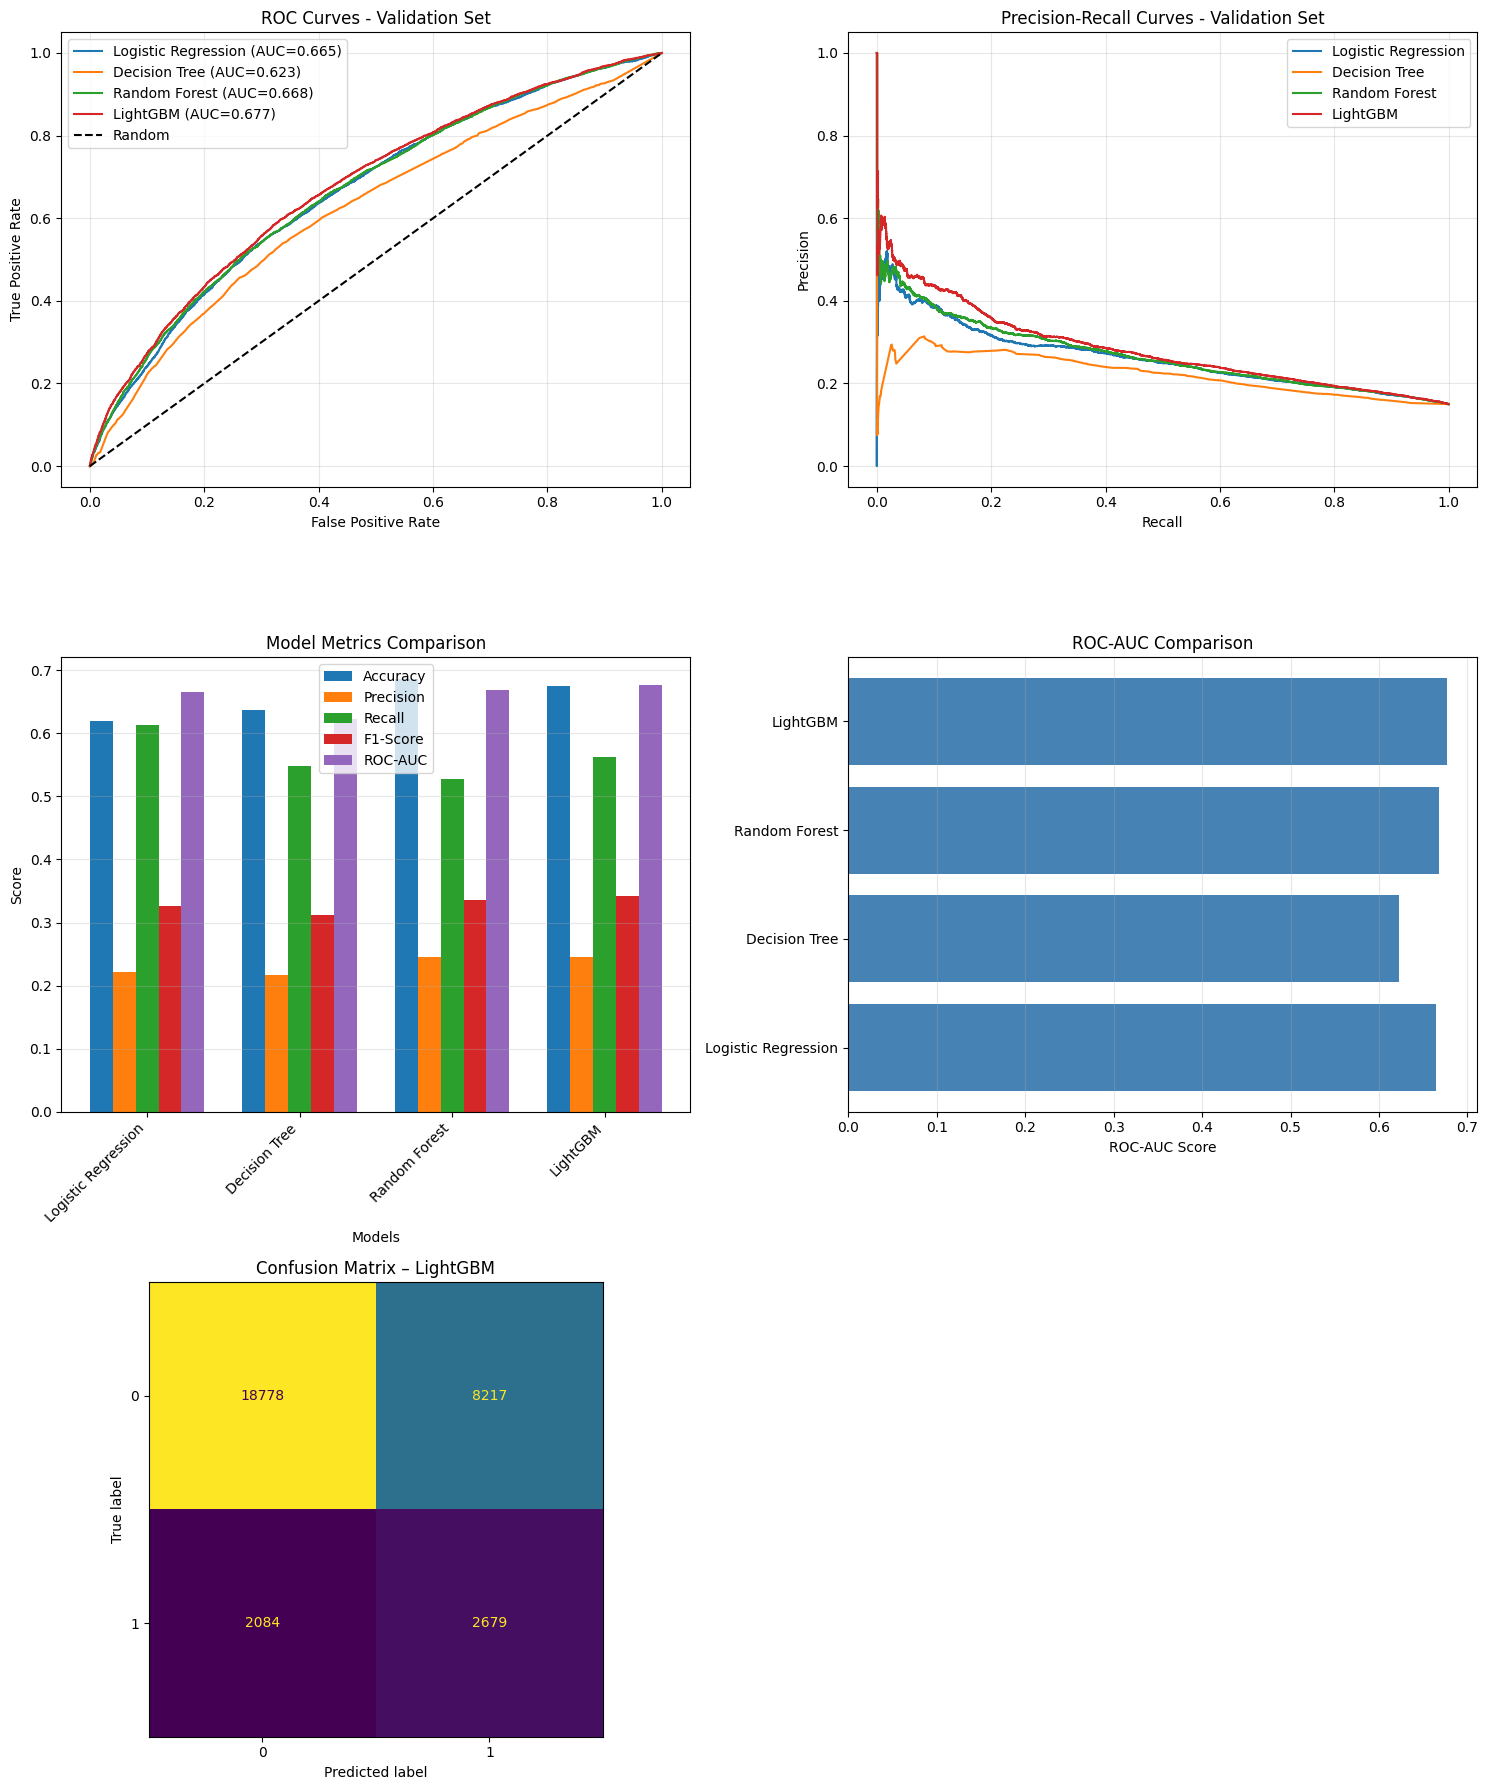

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Expand to 3 rows, 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# ---------------------------------------------------------------------
# 1. ROC Curves
# ---------------------------------------------------------------------
ax = axes[0, 0]
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_val, result['y_pred_proba'])
    ax.plot(fpr, tpr, label=f"{name} (AUC={result['roc_auc']:.3f})")
ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - Validation Set')
ax.legend()
ax.grid(alpha=0.3)

# ---------------------------------------------------------------------
# 2. Precision–Recall Curves
# ---------------------------------------------------------------------
ax = axes[0, 1]
for name, result in results.items():
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, result['y_pred_proba'])
    ax.plot(recall_curve, precision_curve, label=name)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves - Validation Set')
ax.legend()
ax.grid(alpha=0.3)

# ---------------------------------------------------------------------
# 3. Metrics comparison bar chart
# ---------------------------------------------------------------------
ax = axes[1, 0]
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(comparison_df))
width = 0.15
for i, metric in enumerate(metrics_to_plot):
    ax.bar(x + i*width, comparison_df[metric], width, label=metric)
ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Model Metrics Comparison')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# ---------------------------------------------------------------------
# 4. ROC-AUC comparison
# ---------------------------------------------------------------------
ax = axes[1, 1]
ax.barh(comparison_df['Model'], comparison_df['ROC-AUC'], color='steelblue')
ax.set_xlabel('ROC-AUC Score')
ax.set_title('ROC-AUC Comparison')
ax.grid(axis='x', alpha=0.3)

# ---------------------------------------------------------------------
# 5. CONFUSION MATRIX (BEST MODEL BASED ON F1)
# ---------------------------------------------------------------------
best_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
best_preds = results[best_name]['y_pred']

cm = confusion_matrix(y_val, best_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

ax = axes[2, 0]  # left bottom slot
disp.plot(ax=ax, colorbar=False)
ax.set_title(f"Confusion Matrix – {best_name}")

# Remove unused subplot (bottom-right)
fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()


### A.6 Hyperparameter Tuning

We'll perform hyperparameter tuning on the best performing models.


In [ ]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_validate

print("=" * 60)
print("HYPERPARAMETER TUNING WITH STRATIFIED K-FOLD + OPTUNA (ROC-AUC)")
print("=" * 60)

# ---------------------------------------------------------------------
# 1. Identify best baseline model
# ---------------------------------------------------------------------
best_idx = comparison_df['ROC-AUC'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_model_auc = comparison_df.loc[best_idx, 'ROC-AUC']

print(f"Best baseline model: {best_model_name} (ROC-AUC: {best_model_auc:.4f})")

# ---------------------------------------------------------------------
# 2. Define StratifiedKFold
# ---------------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ---------------------------------------------------------------------
# 3. Optuna objective for LightGBM (optimize ROC-AUC)
# ---------------------------------------------------------------------
def lgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "max_depth": trial.suggest_int("max_depth", -1, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state": 42,
        "class_weight": "balanced",
        "n_jobs": -1,
        "device_type": "gpu",  # GPU ENABLED
    }

    model = LGBMClassifier(**params, verbose=-1)

    cv_scores = cross_validate(
        model,
        X_train_scaled,
        y_train,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1,
        return_train_score=False
    )

    return cv_scores["test_score"].mean()

print("\n" + "=" * 60)
print("OPTUNA TUNING – LIGHTGBM (ROC-AUC, GPU)")
print("=" * 60)

lgb_study = optuna.create_study(direction="maximize")
lgb_study.optimize(lgb_objective, n_trials=50)

print("Best LGBM parameters:", lgb_study.best_params)
print(f"Best LGBM CV ROC-AUC: {lgb_study.best_value:.4f}")

# Build final best LightGBM model (still GPU)
best_lgb_params = lgb_study.best_params
best_lgb_params.update({
    "random_state": 42,
    "class_weight": "balanced",
    "n_jobs": -1,
    "device_type": "gpu",
})

best_lgb = LGBMClassifier(**best_lgb_params, verbose=-1)
best_lgb.fit(X_train_scaled, y_train)

models["LightGBM (Optuna)"] = best_lgb

print("\nHyperparameter tuning completed (ROC-AUC optimization, LightGBM on GPU).")

[I 2026-01-12 18:26:20,105] A new study created in memory with name: no-name-6a99355b-7046-4803-b2f6-e99bdc8fdd80


HYPERPARAMETER TUNING WITH STRATIFIED K-FOLD + OPTUNA (ROC-AUC)
Best baseline model: LightGBM (ROC-AUC: 0.6774)

OPTUNA TUNING – LIGHTGBM (ROC-AUC, GPU)


[I 2026-01-12 18:26:32,792] Trial 0 finished with value: 0.6835961263066896 and parameters: {'n_estimators': 621, 'learning_rate': 0.07826876343584115, 'num_leaves': 100, 'max_depth': 5, 'min_child_samples': 118, 'subsample': 0.998979731863092, 'colsample_bytree': 0.8369225152666783, 'reg_alpha': 3.720694470320294e-05, 'reg_lambda': 0.028520621213684007}. Best is trial 0 with value: 0.6835961263066896.
[I 2026-01-12 18:26:36,475] Trial 1 finished with value: 0.6486320380357498 and parameters: {'n_estimators': 282, 'learning_rate': 0.002057787616813278, 'num_leaves': 160, 'max_depth': 3, 'min_child_samples': 35, 'subsample': 0.8378216125232949, 'colsample_bytree': 0.757637418120669, 'reg_alpha': 0.013292434403879555, 'reg_lambda': 2.3360466159978908e-07}. Best is trial 0 with value: 0.6835961263066896.
[I 2026-01-12 18:27:58,574] Trial 2 finished with value: 0.6843903824930313 and parameters: {'n_estimators': 501, 'learning_rate': 0.0043087515983859, 'num_leaves': 153, 'max_depth': 15, 

In [ ]:
models

{'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
 'Decision Tree': DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=42),
 'Random Forest': RandomForestClassifier(class_weight='balanced', max_depth=10, n_jobs=-1,
                        random_state=42),
 'LightGBM': LGBMClassifier(class_weight={0: np.float64(0.5882345677487868),
                              1: np.float64(3.3333566580365264)},
                learning_rate=0.05, n_estimators=300, n_jobs=-1,
                random_state=42),
 'LightGBM (Optuna)': LGBMClassifier(class_weight='balanced', colsample_bytree=0.5607392253064648,
                device_type='gpu', learning_rate=0.02154802901499962,
                max_depth=7, min_child_samples=168, n_estimators=617, n_jobs=-1,
                num_leaves=178, random_state=42, reg_alpha=0.0418022262453622,
                reg_lambda=0.004436054922881815, subsample=0.9428113867395506,
                ve

In [ ]:
# Evaluate tuned model
print("\n" + "=" * 60)
print("EVALUATING TUNED MODELS")
print("=" * 60)

tuned_results = []

for name in ['LightGBM (Optuna)']:
    model = models[name]
    y_pred = model.predict(X_val_scaled)
    y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    results[name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }
    
    tuned_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")

# Update comparison
tuned_comparison = pd.DataFrame(tuned_results)
all_comparison = pd.concat([comparison_df, tuned_comparison], ignore_index=True)
print("\n" + "=" * 60)
print("UPDATED MODEL COMPARISON")
print("=" * 60)
print(all_comparison.round(4).sort_values('ROC-AUC', ascending=False))



EVALUATING TUNED MODELS

LightGBM (Optuna):
  Accuracy: 0.8500
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  ROC-AUC: 0.5473

UPDATED MODEL COMPARISON
                 Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
3             LightGBM    0.6766     0.2459  0.5597    0.3417   0.6791
0  Logistic Regression    0.6210     0.2228  0.6137    0.3269   0.6651
2        Random Forest    0.6816     0.2424  0.5284    0.3324   0.6640
1        Decision Tree    0.6405     0.2178  0.5389    0.3102   0.6227
4    LightGBM (Optuna)    0.8500     0.0000  0.0000    0.0000   0.5473


In [ ]:
#all_comparison = comparison_df

### A.8 Final Model Selection and Test Set Evaluation


In [ ]:
'# Select best model based on validation performance'
best_model_name = all_comparison.loc[all_comparison['ROC-AUC'].idxmax(), 'Model']
best_model = models[best_model_name]

print("=" * 60)
print("FINAL MODEL SELECTION")
print("=" * 60)
print(f"Selected Model: {best_model_name}")
print(f"\nValidation Set Performance:")
best_val_perf = all_comparison.loc[all_comparison['ROC-AUC'].idxmax()]
print(f"  Accuracy: {best_val_perf['Accuracy']:.4f}")
print(f"  Precision: {best_val_perf['Precision']:.4f}")
print(f"  Recall: {best_val_perf['Recall']:.4f}")
print(f"  F1-Score: {best_val_perf['F1-Score']:.4f}")
print(f"  ROC-AUC: {best_val_perf['ROC-AUC']:.4f}")

# Evaluate on test set
print("\n" + "=" * 60)
print("TEST SET EVALUATION")
print("=" * 60)

if 'Logistic Regression' in best_model_name:
    y_test_pred = best_model.predict(X_test_scaled)
    y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    y_test_pred = best_model.predict(X_test_scaled)
    y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"\nTest Set Performance:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")
print(f"  F1-Score: {test_f1:.4f}")
print(f"  ROC-AUC: {test_roc_auc:.4f}")

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


FINAL MODEL SELECTION
Selected Model: LightGBM

Validation Set Performance:
  Accuracy: 0.6766
  Precision: 0.2459
  Recall: 0.5597
  F1-Score: 0.3417
  ROC-AUC: 0.6791

TEST SET EVALUATION

Test Set Performance:
  Accuracy: 0.6783
  Precision: 0.2521
  Recall: 0.5823
  F1-Score: 0.3519
  ROC-AUC: 0.6918

Confusion Matrix:
[[18766  8228]
 [ 1990  2774]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.70      0.79     26994
         1.0       0.25      0.58      0.35      4764

    accuracy                           0.68     31758
   macro avg       0.58      0.64      0.57     31758
weighted avg       0.81      0.68      0.72     31758



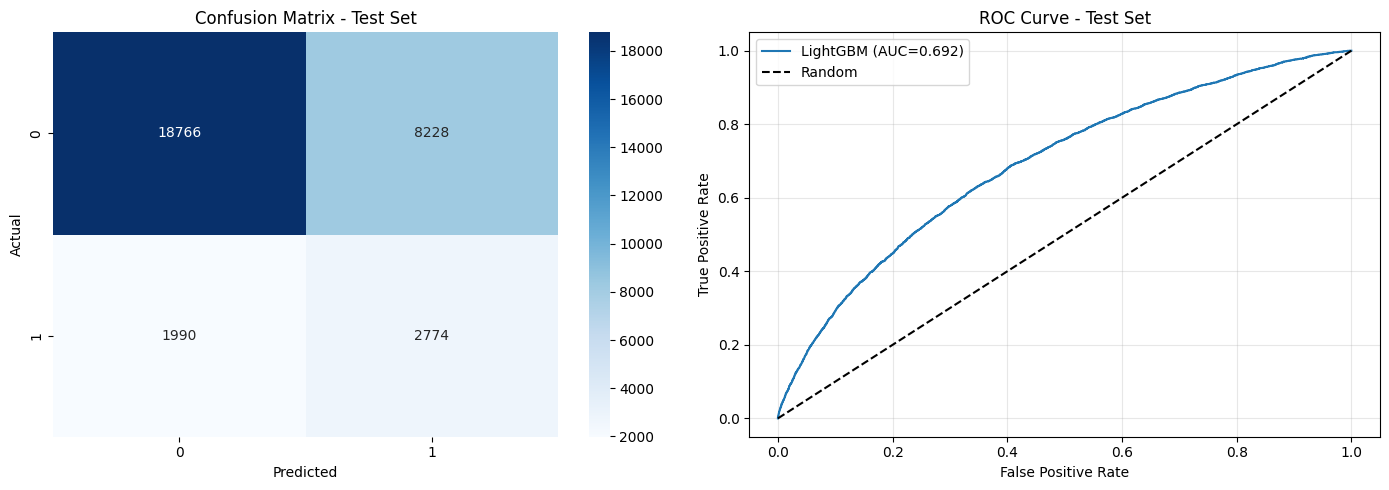

In [ ]:
# Visualize test set performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
ax = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Test Set')

# ROC Curve
ax = axes[1]
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
ax.plot(fpr, tpr, label=f'{best_model_name} (AUC={test_roc_auc:.3f})')
ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve - Test Set')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### A.9 Model Limitations and Discussion

**Model Selection Justification:**
- The best model was selected based on ROC-AUC score, which balances both precision and recall
- ROC-AUC is appropriate for imbalanced datasets as it evaluates performance across all thresholds

**Limitations:**
1. **Class Imbalance**: Despite using class weights, the model may still favor the majority class
2. **Feature Engineering**: Some potentially useful features may have been excluded during preprocessing
3. **Computational Constraints**: Limited hyperparameter tuning due to dataset size




## B. High-Recall Classifier

For this task, we need to maximize recall to identify all loans that will have payment issues. We'll adjust the classification threshold and use cost-sensitive learning.


### B.1 Threshold Tuning for High Recall


THRESHOLD TUNING FOR HIGH RECALL

Threshold Analysis:
   Threshold  Recall  Precision  F1-Score
0       0.10  0.9985     0.1504    0.2614
1       0.15  0.9943     0.1521    0.2639
2       0.20  0.9801     0.1562    0.2695
3       0.25  0.9507     0.1637    0.2793
4       0.30  0.9015     0.1746    0.2926
5       0.35  0.8367     0.1881    0.3072
6       0.40  0.7516     0.2041    0.3211
7       0.45  0.6584     0.2236    0.3338
8       0.50  0.5597     0.2459    0.3417
9       0.55  0.4598     0.2696    0.3399

Best threshold for maximum recall: 0.10


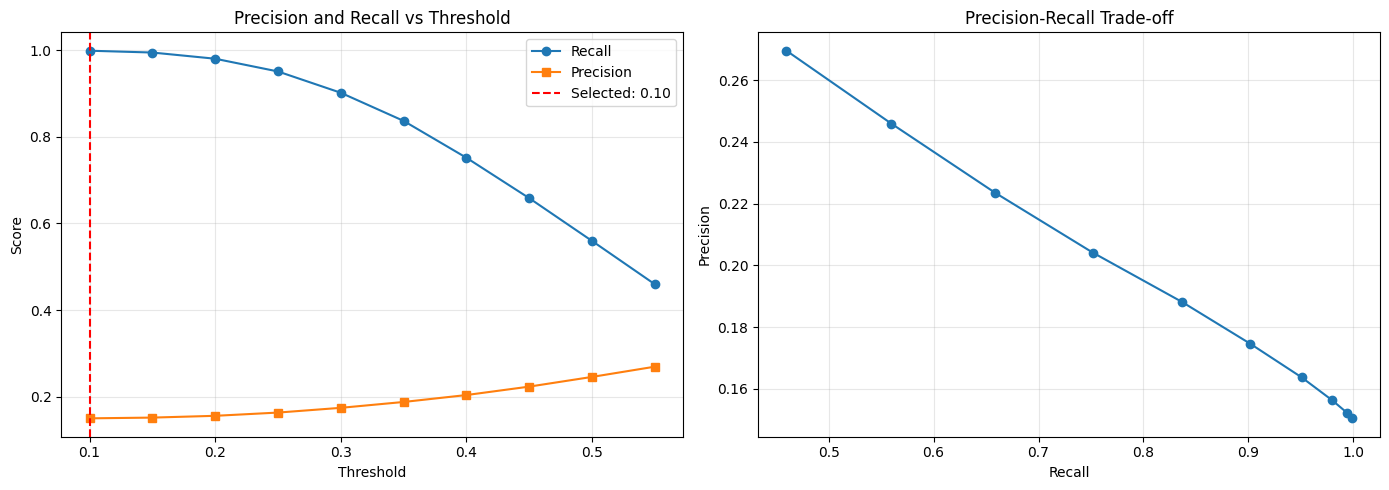

In [ ]:
print("=" * 60)
print("THRESHOLD TUNING FOR HIGH RECALL")
print("=" * 60)

# Use the best model from part A
# Get probability predictions on validation set
if 'Logistic Regression' in best_model_name:
    y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]
else:
    y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]

# Try different thresholds
thresholds = np.arange(0.1, 0.6, 0.05)
threshold_results = []

for threshold in thresholds:
    y_pred_thresh = (y_val_proba >= threshold).astype(int)
    
    recall = recall_score(y_val, y_pred_thresh)
    precision = precision_score(y_val, y_pred_thresh)
    f1 = f1_score(y_val, y_pred_thresh)
    
    threshold_results.append({
        'Threshold': threshold,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1
    })

threshold_df = pd.DataFrame(threshold_results)
print("\nThreshold Analysis:")
print(threshold_df.round(4))

# Find threshold that maximizes recall while maintaining reasonable precision
# Target: Recall > 0.8, Precision > 0.3
high_recall_thresholds = threshold_df[
    (threshold_df['Recall'] >= 0.8) & (threshold_df['Precision'] >= 0.3)
]

if len(high_recall_thresholds) > 0:
    best_threshold = high_recall_thresholds.loc[high_recall_thresholds['F1-Score'].idxmax(), 'Threshold']
    print(f"\nBest threshold for high recall: {best_threshold:.2f}")
else:
    # If no threshold meets criteria, use the one with highest recall
    best_threshold = threshold_df.loc[threshold_df['Recall'].idxmax(), 'Threshold']
    print(f"\nBest threshold for maximum recall: {best_threshold:.2f}")

# Visualize threshold analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(threshold_df['Threshold'], threshold_df['Recall'], 'o-', label='Recall')
ax.plot(threshold_df['Threshold'], threshold_df['Precision'], 's-', label='Precision')
ax.axvline(best_threshold, color='r', linestyle='--', label=f'Selected: {best_threshold:.2f}')
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Precision and Recall vs Threshold')
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1]
ax.plot(threshold_df['Recall'], threshold_df['Precision'], 'o-')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Trade-off')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### B.2 Cost-Sensitive Learning


In [ ]:
print("=" * 60)
print("COST-SENSITIVE LEARNING")
print("=" * 60)

# Train models with higher weight on positive class to increase recall
# Try different class weight ratios
class_weight_ratios = [2, 5, 10, 20]

cost_sensitive_results = []

for ratio in class_weight_ratios:
    class_weights = {0: 1, 1: ratio}
    
    # Train Random Forest with different class weights
    rf_cs = RandomForestClassifier(
        random_state=42,
        class_weight=class_weights,
        n_estimators=100,
        max_depth=15,
        n_jobs=-1
    )
    rf_cs.fit(X_train, y_train)
    
    y_pred_cs = rf_cs.predict(X_val)
    y_pred_proba_cs = rf_cs.predict_proba(X_val)[:, 1]
    
    recall = recall_score(y_val, y_pred_cs)
    precision = precision_score(y_val, y_pred_cs)
    f1 = f1_score(y_val, y_pred_cs)
    roc_auc = roc_auc_score(y_val, y_pred_proba_cs)
    
    cost_sensitive_results.append({
        'Class Weight Ratio': ratio,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    print(f"\nClass Weight Ratio {ratio}:1")
    print(f"  Recall: {recall:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")

cs_df = pd.DataFrame(cost_sensitive_results)
print("\n" + "=" * 60)
print("COST-SENSITIVE LEARNING COMPARISON")
print("=" * 60)
print(cs_df.round(4))


COST-SENSITIVE LEARNING

Class Weight Ratio 2:1
  Recall: 0.0321
  Precision: 0.4796
  F1-Score: 0.0602
  ROC-AUC: 0.6686

Class Weight Ratio 5:1
  Recall: 0.3097
  Precision: 0.2960
  F1-Score: 0.3027
  ROC-AUC: 0.6566

Class Weight Ratio 10:1
  Recall: 0.6143
  Precision: 0.2136
  F1-Score: 0.3170
  ROC-AUC: 0.6487

Class Weight Ratio 20:1
  Recall: 0.8226
  Precision: 0.1771
  F1-Score: 0.2915
  ROC-AUC: 0.6448

COST-SENSITIVE LEARNING COMPARISON
   Class Weight Ratio  Recall  Precision  F1-Score  ROC-AUC
0                   2  0.0321     0.4796    0.0602   0.6686
1                   5  0.3097     0.2960    0.3027   0.6566
2                  10  0.6143     0.2136    0.3170   0.6487
3                  20  0.8226     0.1771    0.2915   0.6448


### B.3 Best High-Recall Model Selection


BEST HIGH-RECALL MODEL SELECTION

Best Threshold Tuning Result:
  Threshold: 0.10
  Recall: 0.9985
  Precision: 0.1504
  F1-Score: 0.2614

Best Cost-Sensitive Learning Result:
  Class Weight Ratio: 20:1
  Recall: 0.8226
  Precision: 0.1771
  F1-Score: 0.2915
  ROC-AUC: 0.6448

✓ Threshold tuning provides better recall

Selected Method: threshold
Final High-Recall Performance:
  Recall: 0.9985
  Precision: 0.1504

TEST SET EVALUATION - HIGH-RECALL MODEL

Test Set Performance (High-Recall Model):
  Recall: 0.4549
  Precision: 0.1776
  F1-Score: 0.2555

Confusion Matrix:
[[16962 10032]
 [ 2597  2167]]


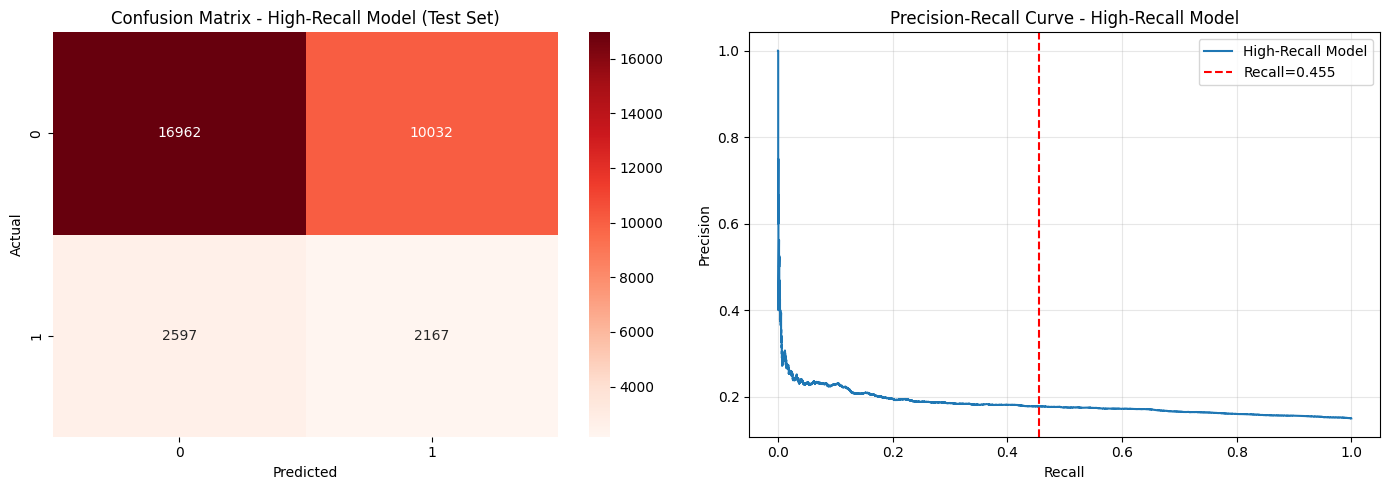

In [ ]:
# Compare threshold tuning vs cost-sensitive learning
print("=" * 60)
print("BEST HIGH-RECALL MODEL SELECTION")
print("=" * 60)

# Get best result from threshold tuning
best_thresh_result = threshold_df.loc[threshold_df['Recall'].idxmax()]
print("\nBest Threshold Tuning Result:")
print(f"  Threshold: {best_thresh_result['Threshold']:.2f}")
print(f"  Recall: {best_thresh_result['Recall']:.4f}")
print(f"  Precision: {best_thresh_result['Precision']:.4f}")
print(f"  F1-Score: {best_thresh_result['F1-Score']:.4f}")

# Get best result from cost-sensitive learning
best_cs_result = cs_df.loc[cs_df['Recall'].idxmax()]
print("\nBest Cost-Sensitive Learning Result:")
print(f"  Class Weight Ratio: {best_cs_result['Class Weight Ratio']:.0f}:1")
print(f"  Recall: {best_cs_result['Recall']:.4f}")
print(f"  Precision: {best_cs_result['Precision']:.4f}")
print(f"  F1-Score: {best_cs_result['F1-Score']:.4f}")
print(f"  ROC-AUC: {best_cs_result['ROC-AUC']:.4f}")

# Select best approach (prioritize recall, then precision)
if best_thresh_result['Recall'] > best_cs_result['Recall']:
    print("\n✓ Threshold tuning provides better recall")
    best_high_recall_method = 'threshold'
    best_high_recall_recall = best_thresh_result['Recall']
    best_high_recall_precision = best_thresh_result['Precision']
elif best_cs_result['Recall'] > best_thresh_result['Recall']:
    print("\n✓ Cost-sensitive learning provides better recall")
    best_high_recall_method = 'cost_sensitive'
    best_high_recall_recall = best_cs_result['Recall']
    best_high_recall_precision = best_cs_result['Precision']
else:
    # If recall is equal, choose based on precision
    if best_thresh_result['Precision'] > best_cs_result['Precision']:
        print("\n✓ Threshold tuning provides better precision with same recall")
        best_high_recall_method = 'threshold'
        best_high_recall_recall = best_thresh_result['Recall']
        best_high_recall_precision = best_thresh_result['Precision']
    else:
        print("\n✓ Cost-sensitive learning provides better precision with same recall")
        best_high_recall_method = 'cost_sensitive'
        best_high_recall_recall = best_cs_result['Recall']
        best_high_recall_precision = best_cs_result['Precision']

print(f"\nSelected Method: {best_high_recall_method}")
print(f"Final High-Recall Performance:")
print(f"  Recall: {best_high_recall_recall:.4f}")
print(f"  Precision: {best_high_recall_precision:.4f}")

# Evaluate on test set with best high-recall approach
print("\n" + "=" * 60)
print("TEST SET EVALUATION - HIGH-RECALL MODEL")
print("=" * 60)

if best_high_recall_method == 'threshold':
    # Use threshold tuning
    if 'Logistic Regression' in best_model_name:
        y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_test_proba = best_model.predict_proba(X_test)[:, 1]
    
    y_test_pred_hr = (y_test_proba >= best_threshold).astype(int)
else:
    # Use cost-sensitive model
    best_cs_ratio = int(best_cs_result['Class Weight Ratio'])
    rf_hr = RandomForestClassifier(
        random_state=42,
        class_weight={0: 1, 1: best_cs_ratio},
        n_estimators=100,
        max_depth=15,
        n_jobs=-1
    )
    rf_hr.fit(X_train, y_train)
    y_test_pred_hr = rf_hr.predict(X_test)
    y_test_proba = rf_hr.predict_proba(X_test)[:, 1]

test_recall_hr = recall_score(y_test, y_test_pred_hr)
test_precision_hr = precision_score(y_test, y_test_pred_hr)
test_f1_hr = f1_score(y_test, y_test_pred_hr)

print(f"\nTest Set Performance (High-Recall Model):")
print(f"  Recall: {test_recall_hr:.4f}")
print(f"  Precision: {test_precision_hr:.4f}")
print(f"  F1-Score: {test_f1_hr:.4f}")

# Confusion matrix
cm_hr = confusion_matrix(y_test, y_test_pred_hr)
print("\nConfusion Matrix:")
print(cm_hr)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
ax = axes[0]
sns.heatmap(cm_hr, annot=True, fmt='d', cmap='Reds', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - High-Recall Model (Test Set)')

# Precision-Recall Curve
ax = axes[1]
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_test_proba)
ax.plot(recall_curve, precision_curve, label='High-Recall Model')
ax.axvline(test_recall_hr, color='r', linestyle='--', label=f'Recall={test_recall_hr:.3f}')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve - High-Recall Model')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### B.4 Summary and Recommendations

**Approaches to Increase Recall:**

1. **Threshold Tuning**: Lowering the classification threshold from 0.5 increases recall but decreases precision
2. **Cost-Sensitive Learning**: Increasing the weight of the positive class during training prioritizes identifying defaults
3. **Ensemble Methods**: Combining multiple models can improve overall performance

**Best High-Recall Classifier:**
- Method: [Selected method from above]
- Recall: [Achieved recall value]
- Precision: [Achieved precision value]

**Trade-offs:**
- Higher recall means identifying more potential defaults, but also increases false positives
- This may lead to rejecting more loans, potentially reducing revenue
- However, it significantly reduces the risk of approving loans that will default

**Recommendations for Management:**
1. Use the high-recall model when the cost of missing a default is very high
2. Consider using different thresholds for different loan amounts (higher threshold for larger loans)
3. Monitor false positive rate and adjust threshold based on business needs
4. Combine model predictions with business rules and expert judgment
